# Representational Geodesic

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.7.1'

## Simple spectral model and translation

Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.460425,  Stdev: 0.175550,  Kurtosis: 3.649574
Image statistics:
  Range: [0.000000, 0.995128]
  Mean: 0.413386,  Stdev: 0.197611,  Kurtosis: 2.456905
torch.Size([1, 1, 32, 32])
torch.Size([11, 1, 32, 32])
(11, 32, 32)


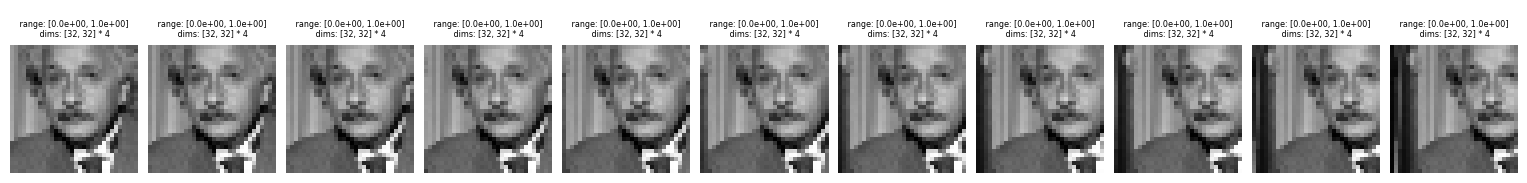

In [13]:
image_size = 64
einstein = po.load_images('../data/256/einstein.pgm')
einstein = po.tools.conv.blur_downsample(einstein, step=(4,4))
vid = po.tools.translation_sequence(einstein[0])
from torchvision.transforms.functional import center_crop
vid = center_crop(vid, image_size // 2)
vid = po.tools.rescale(vid, 0, 1)

imgA = vid[0:1]
imgB = vid[-1:]

pt.image_stats(to_numpy(imgA))
pt.image_stats(to_numpy(imgB))
print(imgA.shape)
print(vid.shape)

# convention: full name for numpy arrays, short hands for torch tensors
video = to_numpy(vid).squeeze()
print(video.shape)
# pt.animshow(video, zoom=4)
pt.imshow(list(video.squeeze()), zoom=4);

In [3]:
# waiting for update to spyr (would be confusing to use both versions of fft)
# import torch.fft
# class Fourier(nn.Module):
#     """
#     add bispectrum
#     """
#     def __init__(self, representation = 'amp'):
#         super().__init__()
#         self.representation = representation
#     def spectrum(self, x):
#         return torch.fft.rfftn(x, dim=(2, 3))


#     def forward(self, x):
#         return torch.abs(self.spectrum(x))
        

# fourier_amp = Fourier('amp')

In [4]:
n_steps = len(video)-1
moog = po.synth.Geodesic(imgA, imgB, fourier_amp, n_steps, init='straight')
moog.synthesize(500, lmbda=.1)

NameError: name 'fourier_amp' is not defined

In [ ]:
moog.plot_loss()
moog.plot_distance_from_line(vid)

In [ ]:
pixelfade = to_numpy(moog.pixelfade.squeeze())
geodesic = to_numpy(moog.geodesic.squeeze())
fig = pt.imshow([video[5], pixelfade[5], geodesic[5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4);

size = geodesic.shape[-1]
h, m , l = (size//2 + size//4, size//2, size//2 - size//4)

# for a in fig.get_axes()[0]:
a = fig.get_axes()[0]
for line in (h, m, l):
    a.axhline(line, lw=2)


pt.imshow([video[:,l], pixelfade[:,l], geodesic[:,l]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,m], pixelfade[:,m], geodesic[:,m]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,h], pixelfade[:,h], geodesic[:,h]],
          title=None, col_wrap=3, zoom=4);

## Vision models demo¶

In [ ]:
# model = po.simul.Linear_Nonlinear()
# po.imshow(model(po.make_basic_stimuli(64)[-1:]), zoom=8);
# po.imshow(model.conv.weight, zoom=28, vrange='auto0');

# TODO
# - speedup front_end -> LGN V1 -> complex
# model = po.simul.Steerable_GainControl(imgB.shape[-2:], is_complex=True,
# n_ori=4, n_scale=5, residuals=False, front_end=True).eval()

# model = po.simul.Spectral(image_size=imgB.shape[-2:], n_scale='auto')

# TODO coupled spectrum

# TODO synthesis fails on polarpyr model 
model = po.simul.Polar_Pyramid(imgB.shape[-2:], n_ori=2)

In [ ]:
n_steps = 10

moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight')

print('shape trainable param', '# trainable param')
#  sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

In [5]:
def get_angles_dist_accel(x):
    """

    Parameters
    ----------
    x:
    [T C H W]
    
    Returns
    -------
    dist  [T-1]
    theta [T-2]
    accel [T-2 H W]
    
    TODO
    ----
    inverse
    """
    T, C, H, W = x.shape

    x = x.view((T, -1))
    v = x[0:T-1] - x[1:T]
    d = torch.norm(v, dim=1, keepdim=True)
    v_hat = torch.div(v, d)

    theta = torch.empty((T-2))
    accel = torch.empty((T-2, H * W))

    for t in range(T-2):
        theta[t] = torch.acos(v_hat[t] @ v_hat[t+1]) / torch.tensor(np.pi) * 180
        
        accel[t] = v_hat[t] - v_hat[t] @ v_hat[t+1] * v_hat[t]

    accel_hat = torch.div(accel, torch.norm(accel, dim=1, keepdim=True))
    accel_hat = accel_hat.view((T-2, C, H, W))

    return theta, d, accel_hat

In [6]:
metamer = po.synth.Metamer(im, frontend)
metamer.synthesize(max_iter=3, store_progress=1)
metamer.plot_synthesis_status(figsize=(35, 5))
metamer.animate(figsize=(35, 5))

NameError: name 'im' is not defined

In [7]:
x = po.tools.sample_brownian_bridge(imgA, imgB, n_steps)
# x = po.tools.make_straight_line(imgA, imgB, n_steps)
x.shape

torch.Size([11, 1, 32, 32])

In [8]:
theta, d, a = get_angles_dist_accel(x)

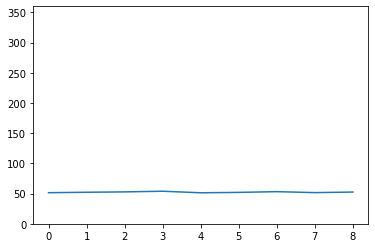

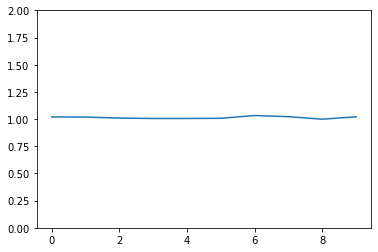

In [9]:
plt.plot(to_numpy(theta))
plt.ylim((0, 360))
plt.show()
plt.plot(to_numpy(d))
plt.ylim((0, 2))
plt.show()

In [10]:
pt.imshow(list(to_numpy(x)));

Exception: Can't figure out how to plot image with shape (1, 32, 32)as RGB(A)! RGB(A) signals should have their finaldimension of shape 3 or 4.

In [11]:
pt.imshow(list(to_numpy(a)));

Exception: Can't figure out how to plot image with shape (1, 32, 32)as RGB(A)! RGB(A) signals should have their finaldimension of shape 3 or 4.

In [12]:
def Haar_1d(x, n_scales=None):
    """
    tool for multiscale geodesic

    in: B 1 T X Y
    Haar decomposition along T axis

    todo:
    work with [T,C,H,W]
    use functionals, to avoid parameters
    """

    if n_scales is None:
        n_scales = int(np.log2(x.shape[-3]))

    diff = nn.Conv3d(1, 1, (2, 1, 1), bias=False)
    blur = nn.Conv3d(1, 1, (2, 1, 1), bias=False, stride=(2, 1, 1))

    diff.weight = nn.Parameter(torch.ones_like(diff.weight))
    diff.weight.select(2, 0).mul_(-1)  # padding = 1 and pop ?
    blur.weight = nn.Parameter(torch.ones_like(diff.weight))

    y = []
    for s in range(n_scales):
        #         print(s, x.shape)
        y.append(diff(x))
        x = blur(x)

    return y


In [13]:
from adabelief_pytorch import AdaBelief
optimizer = AdaBelief(moog.parameters(), lr=0.01, eps=1e-16, betas=(0.9,0.999),
                      weight_decouple = True, rectify = False)

moog.synthesize(optimizer=optimizer, lmbda=0.05)

NameError: name 'moog' is not defined

In [14]:
# gradient clipping
# control bridge
# init images
# logspace 

In [15]:
# TODO where do the NaN come from?

In [16]:
moog.plot_loss()
moog.plot_distance_from_line(vid)

NameError: name 'moog' is not defined

In [17]:
a = moog.animate_distance_from_line(vid)
# a.save("../logs/name.mp4")

NameError: name 'moog' is not defined

In [18]:
# plt.plot(moog.model(moog.geodesic).view(n_steps+1, -1));

In [19]:
torch.stack(moog.dist_from_line, 0).shape

NameError: name 'moog' is not defined

In [20]:
plt.plot(torch.stack(moog.dist_from_line, 0)[:, 1:-1])

plt.title('evolution of distance from representation line')
plt.ylabel('distance from representation line')
plt.xlabel('iteration step')
# plt.yscale('log')
plt.show()

NameError: name 'moog' is not defined

In [21]:
step_lengths = torch.cat(moog.step_energy, dim=0)
# plt.plot(step_lengths[:, 0], 'r--');
plt.plot(step_lengths);
# plt.axhline(po.to_numpy(moog.reference_length / (moog.n_steps - 1)), ls='--', c='k')

plt.xlabel('iteration step')
plt.ylabel('step length')
plt.title('evolution of geodesic step lengths in representation space')

plt.yscale('log')
# plt.ylim([0,2])
# plt.xlim([0,40])
plt.show()

NameError: name 'moog' is not defined

In [22]:
# pt.imshow(list(moog.yA[0]), col_wrap=4);
# pt.imshow(list(moog.yB[0]), col_wrap=4);

In [23]:
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()
assert geodesic.shape == pixelfade.shape

# checking that the range constraint is met
plt.hist(video.flatten(), histtype='step', density=True, label='video')
plt.hist(pixelfade.flatten(), histtype='step', density=True, label='pixelfade')
plt.hist(geodesic.flatten(), histtype='step', density=True, label='geodesic');
plt.yscale('log')
plt.title('signal value histogram')
plt.legend(loc=1)
plt.show()

NameError: name 'moog' is not defined

In [24]:
print('geodesic')
pt.imshow(list(geodesic), vrange='auto1', title=None, zoom=4);
print('diff')
pt.imshow(list(geodesic - pixelfade), vrange='auto1', title=None, zoom=4);
print('pixelfade')
pt.imshow(list(pixelfade), vrange='auto1', title=None, zoom=4);

geodesic


NameError: name 'geodesic' is not defined

### relative

In [25]:
moog.representational_unit

NameError: name 'moog' is not defined

In [26]:
plt.plot((moog.step_energy[-1] - moog.representational_unit).squeeze())

NameError: name 'moog' is not defined

In [27]:
moog.metric(moog.yA - moog.yB) / (moog.n_steps-1)

NameError: name 'moog' is not defined

In [28]:
moog.metric(moog.pixelfade[1] - moog.pixelfade[0])

NameError: name 'moog' is not defined

In [29]:
moog.path_energy(moog.geodesic[1:-1], moog.geodesic[0], moog.geodesic[-1])

NameError: name 'moog' is not defined

## Cross spectral model

In [30]:
x = po.make_basic_stimuli(128)
b, c, h, w = x.shape

PP = po.simul.Polar_Pyramid((h, w))
x_hat = PP.synthesis(PP.analysis(x))
assert (x - x_hat).pow(2).mean() < 1e-10

x.shape

AttributeError: module 'plenoptic.simulate' has no attribute 'Polar_Pyramid'

In [31]:
PP = po.simul.Polar_Pyramid((32, 32), n_ori=2)

yA = PP.analysis(imgA)

AttributeError: module 'plenoptic.simulate' has no attribute 'Polar_Pyramid'

In [32]:
pt.imshow(list(yA.squeeze()), zoom=2, col_wrap=6, vrange='indep1');

NameError: name 'yA' is not defined

In [33]:
(imgA - PP.synthesis(yA)).pow(2).mean()

NameError: name 'PP' is not defined

In [34]:
zA = PP.analysis(torch.transpose(yA[:, 6:], 1, 0))
pt.imshow(list(zA.view(-1, 32, 32).squeeze()), zoom=2, col_wrap=6);

NameError: name 'PP' is not defined

In [35]:
torch_flows = [zA[0, 0:2], zA[1, 0:2], zA[2, 2:4], zA[3, 2:4], zA[4, 2:4], zA[5, 2:4]]
flows = []
for f in torch_flows:
    flows.append(po.to_numpy(torch.transpose(f, 2, 0)))

NameError: name 'zA' is not defined

In [36]:
fig = pt.imshow(list(po.to_numpy(yA[0, 6:])), zoom=10, col_wrap=6, vrange='auto0', title=None);
for ax, flow in zip(fig.axes, flows):
    step = 2
    ax.quiver(np.arange(0, flow.shape[1], step), np.arange(flow.shape[0]-1, -1, -step), 
               flow[::step, ::step, 0], flow[::step, ::step, 1])
plt.show()

fig = pt.imshow(list(po.to_numpy(yA[0, 6:])), zoom=10, col_wrap=6, vrange='auto0', title=None);
for ax, flow in zip(fig.axes, flows):
    step = 2
    flow = flow @ np.array(((0, 1), (-1, 0)))
    ax.quiver(np.arange(0, flow.shape[1], step), np.arange(flow.shape[0]-1, -1, -step), 
               flow[::step, ::step, 0], flow[::step, ::step, 1])
plt.show()

NameError: name 'yA' is not defined

In [37]:
f = torch_flows[0]

NameError: name 'torch_flows' is not defined

In [144]:
from einops import reduce

R = torch.tensor(((0, -1), (1, 0)), dtype=torch.float32)


f_rot = torch.einsum('bc , chw -> bhw', R, f)

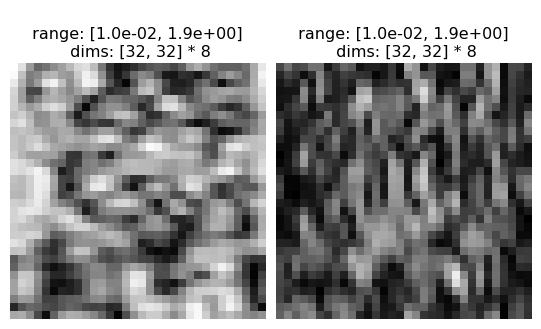

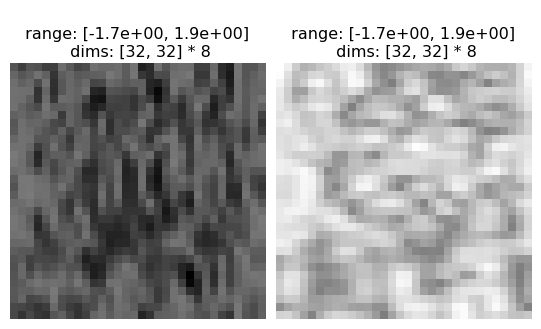

In [145]:
pt.imshow(list(f), vrange='auto1', zoom=8);
pt.imshow(list(f_rot), vrange='auto1', zoom=8);

In [ ]:
PP.synthesis()

In [17]:
zA_modified = zA.clone()
zA_modified[0, 7] = 0

In [18]:
y_recon = model.synthesis(zA_modified)

In [20]:
y_recon = torch.transpose(y_recon, 1, 0)

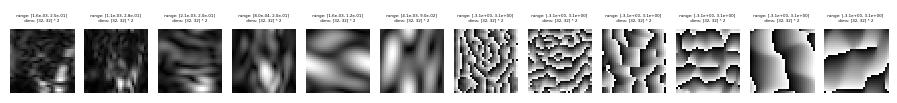

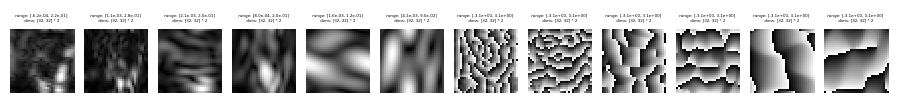

In [25]:
pt.imshow(list(yA.squeeze()), zoom=2);
pt.imshow(list(y_recon.squeeze()), zoom=2);

In [26]:
x_recon = model.synthesis(yA)
x_recon.shape

RuntimeError: Sizes of tensors must match except in dimension 1. Got 12 and 1 in dimension 0 (The offending index is 1)

In [29]:
model

Polar_Pyramid(
  (pyr): Steerable_Pyramid_Freq()
)

**suggestions from Eero**

- realted decomposition
- field of gradient vector - expansion, 2x2 cov mtx
    - energy, trace
    - orientedness, e0 - e1 / e0 + e1
    - orientation, 
    
no inverting back to coeffs

total gradient energy

In [ ]:
model = po.simul.CrossSpectral(image_size=imgB.shape[-2:], n_scale='auto')

In [ ]:
# imgB = vid[-1:]
imgB = torch.flip(imgB, dims=(2,3))

# with torch.no_grad():
yA = model(imgA)
yB = model(imgB)
# imgA.requires_grad, yA.requires_grad

In [ ]:
model.pyr.num_orientations

In [ ]:
pt.imshow(list(po.to_numpy(model.pyr(imgB)[0, 1:1+6])), zoom=3);
pt.imshow(po.to_numpy(model.pyr(imgB)[0, 1]), zoom=3);
pt.imshow(po.to_numpy(model.pyr(imgB)[0, 6]), zoom=3);
pt.imshow([po.to_numpy(model.pyr(imgB)[0, 6] * model.pyr(imgB)[0, 1]),
           po.to_numpy(model.pyr(imgB)[0, 1] * model.pyr(imgB)[0, 2]),
           po.to_numpy(model.pyr(imgB)[0, 2] * model.pyr(imgB)[0, 3])], zoom=3);

In [ ]:
pt.imshow(list(po.to_numpy(model.pyr(imgB)[0, 2] * model.pyr(imgB)[0, 1])[None,...]), zoom=3);

In [ ]:
pt.imshow(list(po.to_numpy(yB[0])[18:-2]), col_wrap=6, zoom=8, vrange='auto0');

In [ ]:
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight')

print('shape trainable param', '# trainable param')
#  sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

## Texture interpolation

In [ ]:
path = '../data/'
nameA = 'reptil_skin'
nameB = 'metal'

imageA = plt.imread(path + nameA + '.pgm') / 255.
imageB = plt.imread(path + nameB + '.pgm') / 255.

c = 64
imageA = imageA[c:-c, c:-c]
imageB = imageB[c:-c, c:-c]
pt.image_stats(imageA)
pt.image_stats(imageB)

imgSize = imageA.shape[0]
pt.imshow([imageA, (imageA + imageB)/2, imageB], vrange='indep1', zoom=2);

In [ ]:
imgA = torch.tensor(imageA, dtype=dtype).unsqueeze(0).unsqueeze(0)
imgB = torch.tensor(imageB, dtype=dtype).unsqueeze(0).unsqueeze(0)

print(imgA.shape)
from plenoptic.tools.straightness import make_straight_line
n_steps = 11
video = make_straight_line(imgA, imgB, n_steps)
print(video.shape)
pt.image_stats(po.to_numpy(video).squeeze())
pt.animshow(po.to_numpy(video).squeeze(), zoom=2)